In [ ]:
!pip install jax jaxlib flax torchvision torch numpy matplotlib optax

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
# as opposed to pytorch, jax handles device (gpu or cpu) placement automatically
# Now let's check whether you are actually using a gpu, if so, the output should be a cuda id, otherwise you are using a cpu
# for this problem, it doesn't really matter since we will train a small neural network

import jax
print(jax.devices())

[CpuDevice(id=0)]


In [ ]:
import torchvision
import torchvision.transforms as transforms
import numpy as np
import jax.numpy as jnp

# These transformations are applied to the data as it is loaded, do not worry too much about them,
# but I leave some explanations on why they are there for you to understand in case you are curious / confused

transform = transforms.Compose(
    (
        transforms.ToTensor(), # This will transform the original data format of the images into pytorch tensors,
        # so that we can use the Normalize transform on them
        transforms.Normalize((0.5,), (0.5,)), # The images are originally scaled between 0 and 1,
        # but generative models would usually standarize them to have 0 mean and 1 std
        transforms.Lambda(lambda x: np.transpose(np.array(x), (1,2,0))), # we will convert pytorch tensors into jax obejects.
        # An odd distinction between jax and pytorch is how they assume image data is formatted.
        # # For pytorch an image has shape (n_channels, n_pixels, n_pixels),
        #  whereas for jax it should be (n_pixels, n_pixels, n_channels), hence the transpose...
    )
)
# Now we will create a dataset that can download and obtain the data we want
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15894994.76it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 479642.75it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 968307.64it/s] 


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7444520.82it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# this is how we can get one example from our dataset
image, target = train_dataset[5]

In [ ]:
# the label of the example
target

2

In [ ]:
# the shape of the example. This is an image with one channel (grayscale) and 28 pixels

image.shape

(28, 28, 1)

Text(0.5, 1.0, 'Target = 2')

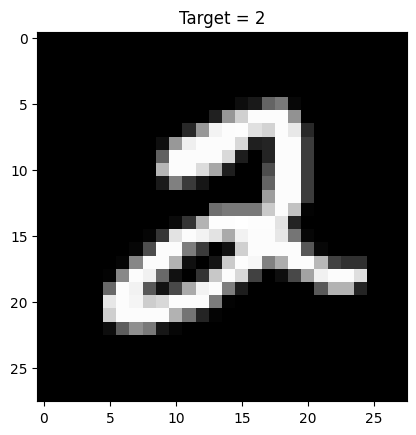

In [ ]:
# and let's have a look at the image using matplotlib
#TODO always check your data loader and make sure the labels seem sensible by visual inspection,
# here, play with index to see different images

index = 5
image, target = train_dataset[index]

import matplotlib.pyplot as plt
plt.imshow(image[:,:,0], cmap='gray')
plt.title(f'Target = {target}')

In [ ]:
# but we want to get batches (groups) of examples from the training set, for that we will need a data loader
# that randomly loads batches of examples:
from torch.utils.data import DataLoader
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

train_loader = iter(train_dataloader)

In [ ]:
# Now when we call batch, we get a fresh batch of data and labels
x_batch, y_batch = next(train_loader)

In [ ]:
x_batch.shape

#TODO: what shape do you expect x_batch to have? Write down your guess for expected_shape here:  (64, 28, 28, 1)

expected_shape = (64, 28, 28, 1)
assert x_batch.shape == expected_shape

In [ ]:


import flax.linen as nn

class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = x.reshape((x.shape[0], -1))  # Flatten the input
        #TODO : Write a multi layer perceptron using jax, apply dense layers and non-linearities,
        # until you reach the desired output size

        # First hidden layer
        x = nn.Dense(features=512)(x)
        x = nn.relu(x)

        # Second hidden layer
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)

        # Third hidden layer
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)  # Non-linearity

        # Output layer
        x = nn.Dense(features=10)(x)  # Output should match the desired output size (10 classes)


        return x

model = MLP()

In [ ]:

example_input = jnp.ones((64,28,28,1))
params = model.init(jax.random.PRNGKey(0), example_input)  # Example input for shape inference


In [ ]:
# let's look at params, it should be a dictionary containing the parameters' names and values
params

{'params': {'Dense_0': {'kernel': Array([[-0.03913071,  0.05444214,  0.04740295, ...,  0.06523017,
            0.0119872 ,  0.08043634],
          [ 0.01668965, -0.00612889,  0.00993335, ..., -0.02016362,
            0.04787786,  0.0510066 ],
          [-0.04086368,  0.05011394, -0.00382218, ...,  0.03551805,
            0.00043432,  0.01461799],
          ...,
          [ 0.00547553, -0.02139576,  0.03528886, ..., -0.06179287,
            0.02263864, -0.02301445],
          [ 0.03864831, -0.00599695,  0.00455287, ...,  0.00773665,
           -0.04161145, -0.03113718],
          [-0.08020224, -0.06572444, -0.06583147, ..., -0.04730776,
           -0.01103787,  0.02308792]], dtype=float32),
   'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [ ]:
# Let's now see how the neural network output looks like:
# the way models are called are through the apply function, that takes the parameters as an argument, and the inputs to the neural network. In this case, our images
y = model.apply(params, x_batch)

In [ ]:

# TODO: check the shape of the output, what were you expecting? (64, 10)
y.shape

expected_ouptut_shape = (64, 10)
assert y.shape == expected_ouptut_shape

In [ ]:
# You can have a look at the shape of the parameters of the first layer in the neural network, the Dense_0 layer
params['params']['Dense_0']['kernel'].shape

(784, 512)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 512.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([-0.5       , -0.44999999, -0.40000001, -0.34999999, -0.30000001,
        -0.25      , -0.2       , -0.15000001, -0.1       , -0.05      ,
         0.        ,  0.05      ,  0.1       ,  0.15000001,  0.2       ,
         0.25      ,  0.30000001,  0.34999999,  0.40000001,  0.44999999,
         0.5       ]),
 <BarContainer object of 20 artists>)

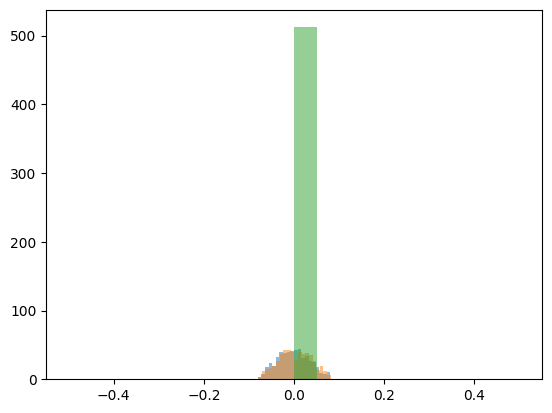

In [ ]:
# let's look at the histograms of some of parameter values, that will show us how they were initialized
# so it looks like the biases were initialized to 0, but not the kernels , that seem to be Gaussian distributed
plt.hist(params['params']['Dense_0']['kernel'][0], bins=20, alpha=0.5,)
plt.hist(params['params']['Dense_0']['kernel'][10], bins=20, alpha=0.5,)
plt.hist(params['params']['Dense_0']['bias'], bins=20, alpha=0.5,)

In [ ]:
def log_softmax(logits):
    # First because we are going to exponentiate the logits, we need to make sure they are not too large,
    # to avoid numerical instability in exp of a large number.
    # Note that shifting the logits by a constant does not change the softmax probabilities
    shifted_logits = logits - jnp.max(logits, axis=-1, keepdims=True)
    # Now you can compute the log softmax using the shifted logits for the todo
    log_softmax_value = shifted_logits - jnp.log(jnp.sum(jnp.exp(shifted_logits), axis=-1, keepdims=True))
    return log_softmax_value

# Define the cross_entropy_loss function
def cross_entropy_loss(logits, labels, num_classes=10):
    log_probabilities = log_softmax(logits)
    # one_hot will give us y_i (which is an array of zeros with a 1 at the index of the true label)
    one_hot = jax.nn.one_hot(labels, num_classes=num_classes)
    return -jnp.mean(jnp.sum(one_hot * log_probabilities, axis=-1))

# Dummy labels for testing
labels = jnp.arange(64) % 10

# Calculate the cross-entropy loss
loss = cross_entropy_loss(y, labels)
print("Cross-Entropy Loss:", loss)

Cross-Entropy Loss: 2.3724601


In [ ]:

# TODO: Check that the loss works as expected:

assert cross_entropy_loss(jnp.array([1000., 0.,]), jnp.array(0.), num_classes=2,) == 0.
assert cross_entropy_loss(jnp.array([0., 1000.,]), jnp.array(0.), num_classes=2,) > 0.

print("All tests passed!")

All tests passed!


In [ ]:
import optax

learning_rate = 1.e-3
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

In [ ]:
# The training step:
# computes the loss function for one batch of examples, and uses its gradients to update the parameters

@jax.jit
def train_step(params, opt_state, batch):
    images, labels = batch
    def loss_fn(params):
        logits = model.apply(params, images)
        loss = cross_entropy_loss(logits, labels)
        return loss
    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss



In [ ]:
from tqdm import tqdm

# Now we will train the model for many steps, in each step we update the parameters with the gradients of the loss function
num_steps = 1_000


train_loss = []

with tqdm(total=num_steps, desc='Training', unit='step') as pbar:
    for step in range(num_steps):
        try:
            images, labels = next(train_loader)
        except StopIteration:
            # Once the dataset is empty, we will reinitialize the data loader to keep training
            train_loader = iter(train_dataloader)
            images, labels = next(train_loader)
        images, labels = jnp.array(images), jnp.array(labels)

        params, opt_state, loss = train_step(params, opt_state, (images, labels))
        train_loss.append(loss)
        pbar.set_postfix(loss=loss)
        pbar.update(1)

Training: 100%|██████████| 1000/1000 [00:38<00:00, 25.68step/s, loss=0.2225809]


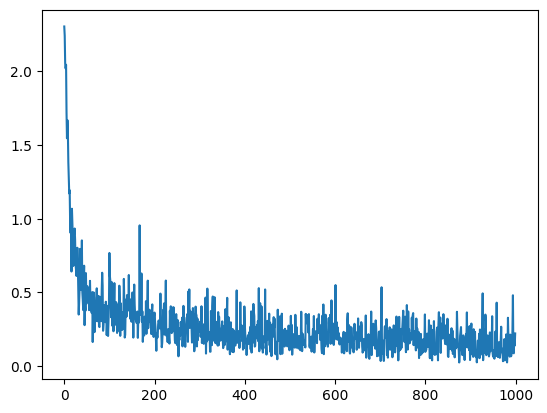

In [ ]:
plt.plot(train_loss)

In [ ]:
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)


In [ ]:
# Final evaluation on the test set
test_accuracy = 0
num_batches = 0
for batch in test_loader:
    images, labels = batch
    images, labels = jnp.array(images), jnp.array(labels)

    # Get the model predictions by finding the class with the highest probability
    logits = model.apply(params, images)
    predictions = jnp.argmax(logits, axis=-1)
    test_accuracy += jnp.mean(predictions == labels)
    num_batches += 1

test_accuracy /= num_batches
print(f'Final Test Accuracy: {test_accuracy * 100:.2f}%')

Final Test Accuracy: 93.88%


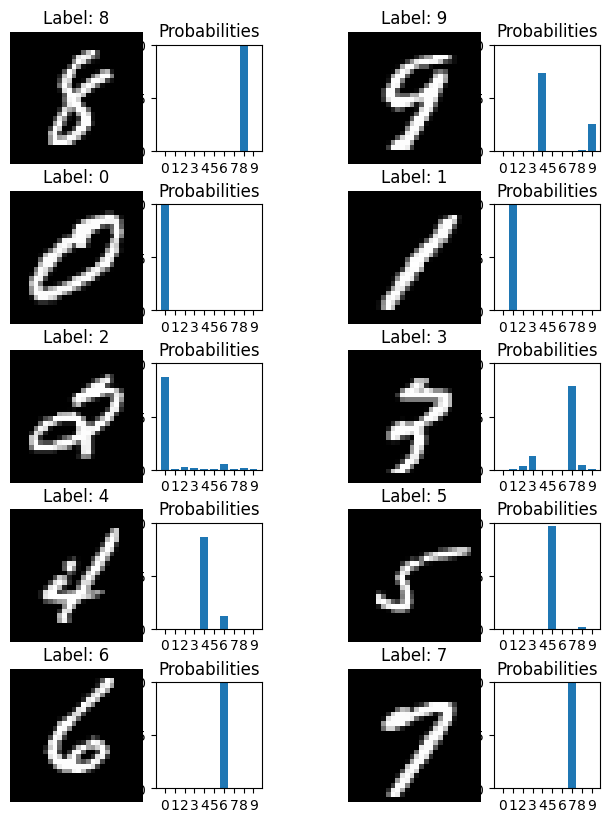

In [ ]:
# let's look at the output probabilities for a few examples from the last batch computed on the previous cell

# Define the softmax function to convert logits to probabilities
def softmax(logits):
    exp_logits = jnp.exp(logits - jnp.max(logits, axis=-1, keepdims=True))
    return exp_logits / jnp.sum(exp_logits, axis=-1, keepdims=True)

# Calculate the probabilities from the logits
probabilities = softmax(logits)

# Visualize the output probabilities for a few examples from the last batch
fig, axs = plt.subplots(5, 2, figsize=(8, 10))

for i in range(10):
    img = images[i][:, :, 0]
    label = labels[i]
    prob = probabilities[i]
    ax = axs[i // 2, i % 2]
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Label: {label}')

    ax_prob = ax.inset_axes([1.1, 0.1, 0.8, 0.8])
    ax_prob.bar(range(10), prob)
    ax_prob.set_xticks(range(10))
    ax_prob.set_ylim(0, 1)
    ax_prob.set_title('Probabilities')



#plt.tight_layout()

plt.show()


